# Benchmarking

The goal of this notebook is to test the various tools we have defined to see which perform the best. Taking from the study by Santamaría, Mihaljević (2018), this can be defined by looking at which tools perform the best on a series of 4 metrics, as defined below : 
- *errorCoded*
- *errorCodedWithoutNa*
- *naCoded*
- *errorGenderBias*

On top of this, we add the *weighted error*, which allows a balance by valuing non-classification less strongly than misclassification via the use of a parameter $w$. 

On the same dataset, we also define the relative statistical value of including the origine within the test. We use the McNemar's test to define if the origine really helped the tools make more precise inference, or if it was just a fluke. 

## Getting the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%cd ../..
from notebooks.helpers.evaluator import Evaluator, StatisticalTester, EvalManager
%load_ext autoreload
%autoreload 2

c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche


C:\Users\brief\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
code_to_continent_table = pd.read_csv('C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/rawData/countryCodesToContinent/country-and-continent-codes-list.csv')
CountryToContinent = code_to_continent_table[['Two_Letter_Country_Code', 'Continent_Code']].fillna(
    'NA').drop_duplicates(
        subset='Two_Letter_Country_Code', keep='first').set_index('Two_Letter_Country_Code')['Continent_Code'].to_dict()


In [3]:
df_masterTest = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/masterTest.csv")

C:\Users\brief\AppData\Local\Temp\ipykernel_17224\3181202359.py:1: DtypeWarning: Columns (8,10,15,16,17,18,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_masterTest = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/masterTest.csv")


In [4]:
df_master_noUnknown = df_masterTest.loc[df_masterTest['index']!='unknown', :]
df_master_noUnknown['index'].value_counts(dropna=False)

index
8       12
12      12
17      12
18      12
20      12
        ..
8784     2
8785     2
8786     2
8791     2
9079     1
Name: count, Length: 14821, dtype: int64

In [5]:
check = df_master_noUnknown['index'].apply(int)
df_master_noUnknown['index'] = check
df_master_noUnknown.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128684 entries, 0 to 128683
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   index                        128684 non-null  int64  
 1   fullName                     128684 non-null  object 
 2   namePassed                   128574 non-null  object 
 3   correctGender                128684 non-null  object 
 4   predictedGender              128684 non-null  object 
 5   localization                 127204 non-null  object 
 6   useLocalization              128684 non-null  bool   
 7   serviceUsed                  128684 non-null  object 
 8   extra_useFullName            25717 non-null   object 
 9   extraProbability             76597 non-null   float64
 10  extraIdentifiedFirstName     25114 non-null   object 
 11  extraIdentifiedLastName      0 non-null       float64
 12  isCorrect                    128684 non-null  bool   
 13  sour

In [6]:
df_master_noUnknown['useLocalization'].value_counts(dropna=False)

useLocalization
False    65095
True     63589
Name: count, dtype: int64

# Base metric and stat

In [7]:
manager = EvalManager()

## conf matrix without useLocal whole dataset

In [8]:
manager.getConfMatrix(df_master_noUnknown, False)

Conf matrix for genderAPI.io without useLocal
   f_pred  m_pred  u_pred
f    5882     465      52
m     294    6247      79
13019
------------
Conf matrix for genderize.IO without useLocal
   f_pred  m_pred  u_pred
f    5865     460      74
m     271    6266      83
13019
------------
Conf matrix for genderGuesser without useLocal
   f_pred  m_pred  u_pred
f    4609     186    1604
m     167    4864    1589
13019
------------
Conf matrix for NamSor without useLocal
   f_pred  m_pred  u_pred
f    5879     520       0
m     363    6257       0
13019
------------
Conf matrix for genderAPI.com without useLocal
   f_pred  m_pred  u_pred
f    5693     528     178
m     225    6203     192
13019
------------


## conf matrix with useLocal whole dataset

In [9]:
manager.getConfMatrix(df_master_noUnknown, True)

Conf matrix for genderAPI.io with useLocal
   f_pred  m_pred  u_pred
f    5773     505       2
m     231    6209       2
12722
------------
Conf matrix for genderize.IO with useLocal
   f_pred  m_pred  u_pred
f    5756     453      72
m     265    6099      78
12723
------------
Conf matrix for genderGuesser with useLocal
   f_pred  m_pred  u_pred
f    2434      62    3785
m      52    2584    3806
12723
------------
Conf matrix for NamSor with useLocal
   f_pred  m_pred  u_pred
f    5846     435       0
m     280    6162       0
12723
------------
Conf matrix for genderAPI.com with useLocal
   f_pred  m_pred  u_pred
f    5662     438     181
m     173    6056     188
12698
------------


In [10]:
df_master_noUnknown.columns

Index(['index', 'fullName', 'namePassed', 'correctGender', 'predictedGender',
       'localization', 'useLocalization', 'serviceUsed', 'extra_useFullName',
       'extraProbability', 'extraIdentifiedFirstName',
       'extraIdentifiedLastName', 'isCorrect', 'source', 'extraTotalName',
       'extraCountryUsedByService', 'extraUsedAI', 'extraForcedGenderize',
       'extraPreciseGenderPredicted', 'extraCount', 'extraGenderScale',
       'extraScore', 'extraProbabilityCalibrated', 'extraScript'],
      dtype='object')

## metric on whole dataset

In [11]:
stat_df_whole, metric_df_whole = manager.getMetricWholeDataset(df_master_noUnknown)

In [12]:
metric_df_whole.round(4)[['service_used', 'useLocal', 'error_with_unknown', 'error_without_unknown']]

,service_used,useLocal,error_with_unknown,error_without_unknown
0,NamSor,True,0.0562,0.0562
0,NamSor,False,0.0678,0.0678
0,genderAPI.com,True,0.0772,0.0496
0,genderAPI.com,False,0.0863,0.0595
0,genderAPI.io,True,0.0582,0.0579
0,genderAPI.io,False,0.0684,0.0589
0,genderGuesser,True,0.6056,0.0222
0,genderGuesser,False,0.2724,0.0359
0,genderize.IO,True,0.0682,0.0571
0,genderize.IO,False,0.0682,0.0568


In [13]:
metric_df_whole['diff'] = metric_df_whole['error_with_unknown'] - metric_df_whole['error_without_unknown']
metric_df_whole[metric_df_whole['useLocal']==True].sort_values('weighted_error').round(4)

,service_used,useLocal,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,diff
0,genderAPI.com,True,0.0772,0.0496,0.0291,-0.0215,0.0552,0.0276
0,NamSor,True,0.0562,0.0562,0.0000,-0.0122,0.0562,0.0000
0,genderAPI.io,True,0.0582,0.0579,0.0003,-0.0215,0.0579,0.0003
0,genderize.IO,True,0.0682,0.0571,0.0118,-0.0150,0.0594,0.0111
0,genderGuesser,True,0.6056,0.0222,0.5966,-0.0019,0.2454,0.5834


In [14]:
metric_df_whole[metric_df_whole['useLocal']==False].loc[:, metric_df_whole.columns!='useLocal'].sort_values('error_with_unknown').round(4)

,service_used,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,diff
0,NamSor,0.0678,0.0678,0.0000,-0.0121,0.0678,0.0000
0,genderize.IO,0.0682,0.0568,0.0121,-0.0147,0.0591,0.0114
0,genderAPI.io,0.0684,0.0589,0.0101,-0.0133,0.0608,0.0095
0,genderAPI.com,0.0863,0.0595,0.0284,-0.0240,0.0650,0.0267
0,genderGuesser,0.2724,0.0359,0.2453,-0.0019,0.0948,0.2364


In [15]:
stat_df_whole

,service_used,statistic,p_value,b,c,odds_ratio,cohen_g,ci_low,ci_high
0,NamSor,56.0,3.900842e-22,56,210,3.750000,0.578947,2.792617,5.035600
0,genderAPI.com,108.0,1.341608e-10,108,225,2.083333,0.351351,1.656200,2.620624
0,genderAPI.io,176.0,7.739351e-10,176,312,1.772727,0.278689,1.473660,2.132488
0,genderGuesser,1254.0,0.000000e+00,5506,1254,0.227752,-0.628994,0.214204,0.242156
0,genderize.IO,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN


In [16]:
stat_df_whole[['service_used','ci_low', 'ci_high']]

,service_used,ci_low,ci_high
0,NamSor,2.792617,5.035600
0,genderAPI.com,1.656200,2.620624
0,genderAPI.io,1.473660,2.132488
0,genderGuesser,0.214204,0.242156
0,genderize.IO,NaN,NaN


# Metric per country

In [17]:
df_metricPerCountry = manager.metricPerCountry(masterdf=df_master_noUnknown, threshhold=10)

c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:60: RuntimeWarning: invalid value encountered in scalar divide
  error_without_unknown = (conf_matrix.loc['f', 'm_pred'] + conf_matrix.loc['m', 'f_pred']) / \
c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:87: RuntimeWarning: invalid value encountered in scalar divide
  error_gender_bias = (conf_matrix.loc['m', 'f_pred'] - conf_matrix.loc['f', 'm_pred']) / \
c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:72: RuntimeWarning: invalid value encountered in scalar divide
  error_with_unknown = (true_f_and_m - true_pred_f_and_m) / true_f_and_m
c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:80: RuntimeWarning: invalid value encountered in scalar divide
  e

In [18]:
df_metricPerCountry['continent'] = df_metricPerCountry['country'].map(CountryToContinent)
df_metricPerCountry

,service_used,country,useLocal,population,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,continent
0,NamSor,BD,False,6.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
0,NamSor,PY,False,32.0,0.031250,0.031250,0.0,0.03125,0.031250,SA
0,NamSor,FI,False,66.0,0.060606,0.060606,0.0,0.00000,0.060606,EU
0,NamSor,TM,False,6.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
0,NamSor,YE,False,3.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
...,...,...,...,...,...,...,...,...,...,...
0,genderize.IO,ZW,True,20.0,0.100000,0.100000,0.0,0.10000,0.100000,AF
0,genderize.IO,SA,True,7.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
0,genderize.IO,KG,True,10.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
0,genderize.IO,SV,True,6.0,0.000000,0.000000,0.0,0.00000,0.000000,NA


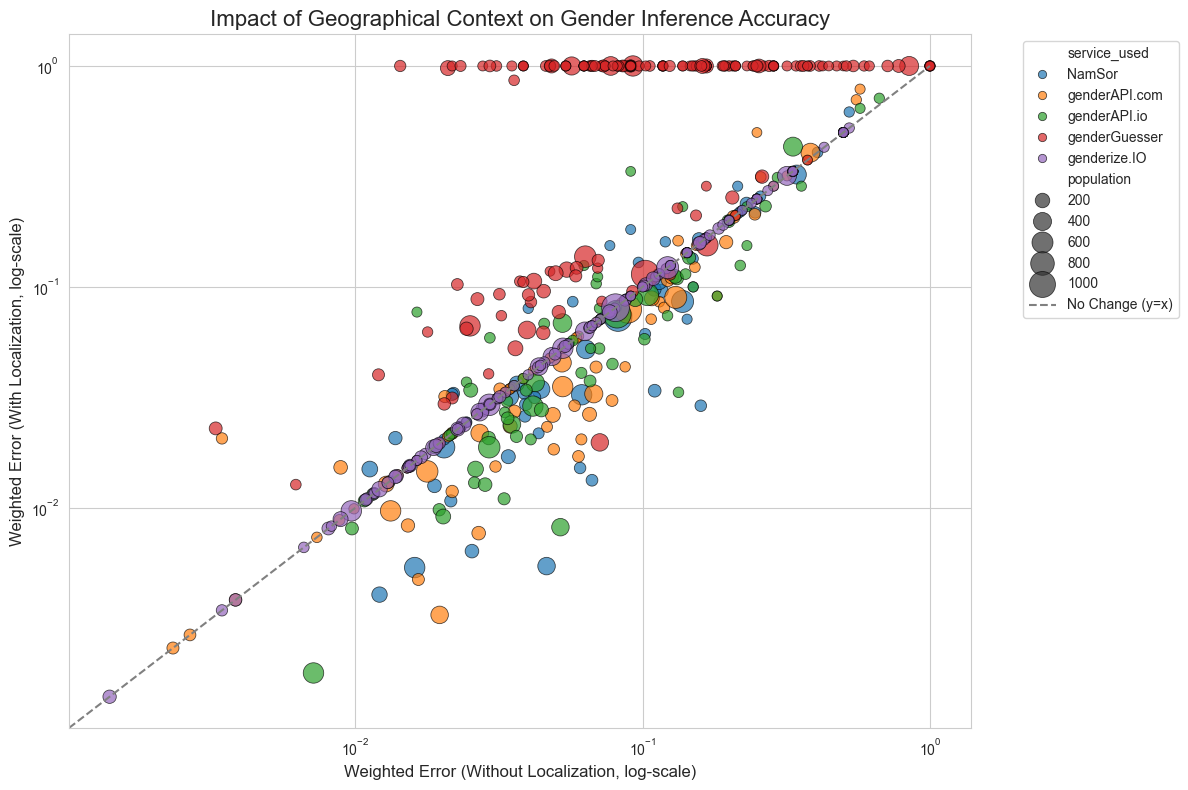

In [19]:
# 1. Transform the data
# We pivot the table so we have one column for 'False' (No Local) and one for 'True' (With Local)
# This aligns the data so every row represents ONE country for ONE tool.


df_pivot = df_metricPerCountry.pivot_table(
    index=['service_used', 'country', 'population'], 
    columns='useLocal', 
    values='weighted_error'
).reset_index()

# Rename the new columns for easier plotting
df_pivot = df_pivot.rename(columns={False: 'Error_No_Local', True: 'Error_With_Local'})

# 2. Setup the Plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 3. Create the Scatter Plot
sns.scatterplot(
    data=df_pivot,
    x='Error_No_Local',
    y='Error_With_Local',
    hue='service_used',      # Color by Tool
    size='population',       # Size by N
    sizes=(50, 400),         # Min/Max size of bubbles
    alpha=0.7,               # Transparency to see overlapping points
    edgecolor='black'
)

# 4. Add the Diagonal Line (y=x)
# This line represents "No Change".
max_val = max(df_pivot['Error_No_Local'].max(), df_pivot['Error_With_Local'].max())
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='No Change (y=x)')

# 5. Add Labels and Titles
plt.title('Impact of Geographical Context on Gender Inference Accuracy', fontsize=16)
plt.xlabel('Weighted Error (Without Localization, log-scale)', fontsize=12)
plt.ylabel('Weighted Error (With Localization, log-scale)', fontsize=12)
# plt.xlim((-0.1, 0.5))
# plt.ylim((-0.1, 0.5))
plt.xscale('log')
plt.yscale('log')


# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

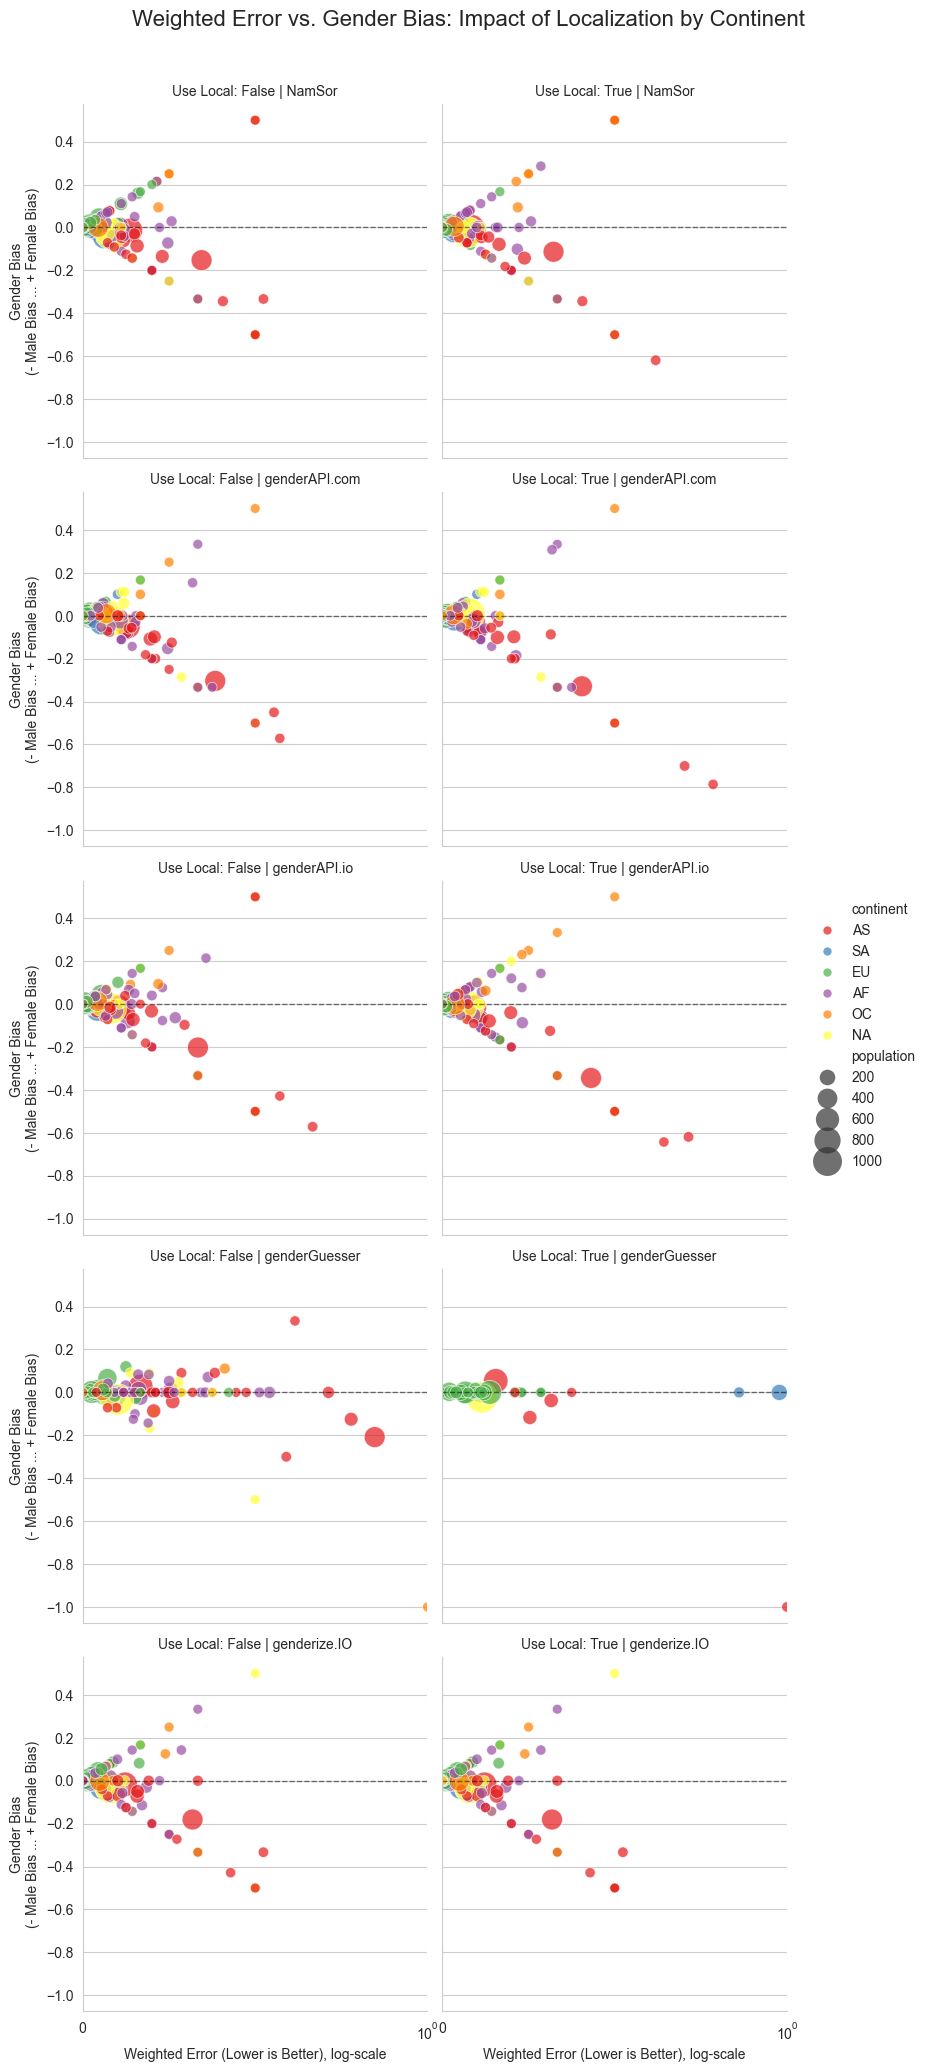

In [20]:
df = df_metricPerCountry.reset_index(drop=True)

# --- 2. Plotting ---
sns.set_style("whitegrid")

# Create the FacetGrid
g = sns.relplot(
    data=df,
    x='weighted_error',
    y='error_gender_bias',
    hue='continent',       # Color by Continent
    col='useLocal',    # Columns = Tools
    row='service_used',        # Rows = Conditions
    size='population',     # Bubble size
    sizes=(50, 500),       # Size range
    kind='scatter',
    palette='Set1',        # Distinct colors
    alpha=0.7,             # Transparency
    height=4,              # Height per subplot
    aspect=1
)

# --- 3. Customizations ---

# Add Reference Lines to ALL subplots
# Horizontal line at 0 (No Bias)
g.map(plt.axhline, y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
# Vertical line at 0 (Zero Error)
g.map(plt.axvline, x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# Titles and Labels
g.fig.suptitle('Weighted Error vs. Gender Bias: Impact of Localization by Continent', y=1.03, fontsize=16)
g.set_axis_labels("Weighted Error (Lower is Better), log-scale", "Gender Bias\n(- Male Bias ... + Female Bias)")
g.set_titles(col_template="{row_name}", row_template="Use Local: {col_name}")
g.set(xscale="symlog", xlim=(0, 1.0))

# Adjust Legend
# sns.relplot handles the legend automatically, but we can move it if needed.
# typically it places it outside to the right.

plt.show()

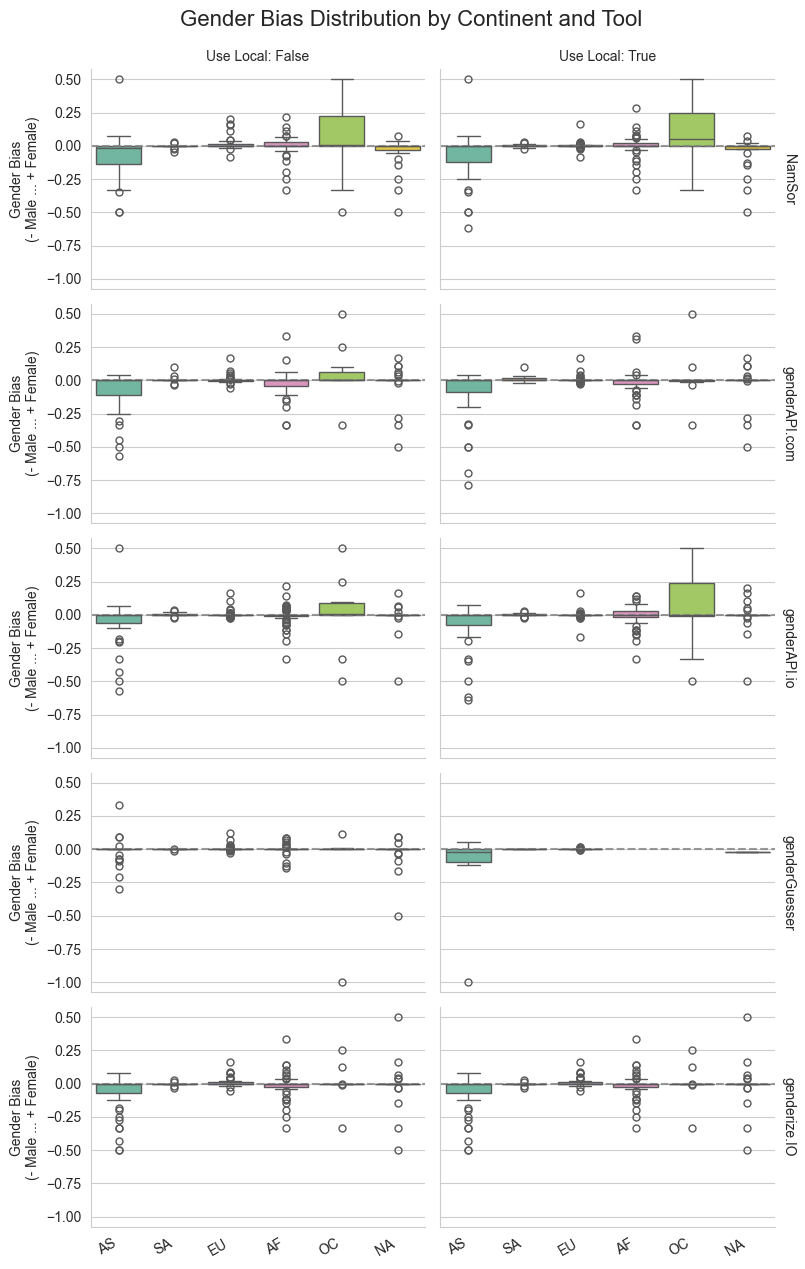

In [21]:
df = df_metricPerCountry.reset_index(drop=True)

# --- 2. Plotting ---
sns.set_style("whitegrid")

g = sns.catplot(
    data=df,
    x='continent',
    y='error_gender_bias',
    col='useLocal',      
    row='service_used',  
    kind='box',          
    hue='continent',    
    palette='Set2',      
    height=2.5,          
    aspect=1.6,          
    dodge=False,        
    margin_titles=True  
)

# --- Aesthetic Upgrades ---

# 1. Add the "Zero Bias" Reference Line (Essential!)
# This lets you instantly see if a continent is consistently "above" (Female Bias)
# or "below" (Male Bias) the center.
g.map(plt.axhline, y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)

# 2. Fix Labels
g.fig.suptitle('Gender Bias Distribution by Continent and Tool', y=1.02, fontsize=16)
g.set_axis_labels("", "Gender Bias\n(- Male ... + Female)")
g.set_titles(col_template="Use Local: {col_name}", row_template="{row_name}")


# 3. Rotate X-Axis Labels (to fit "North America" etc.)
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

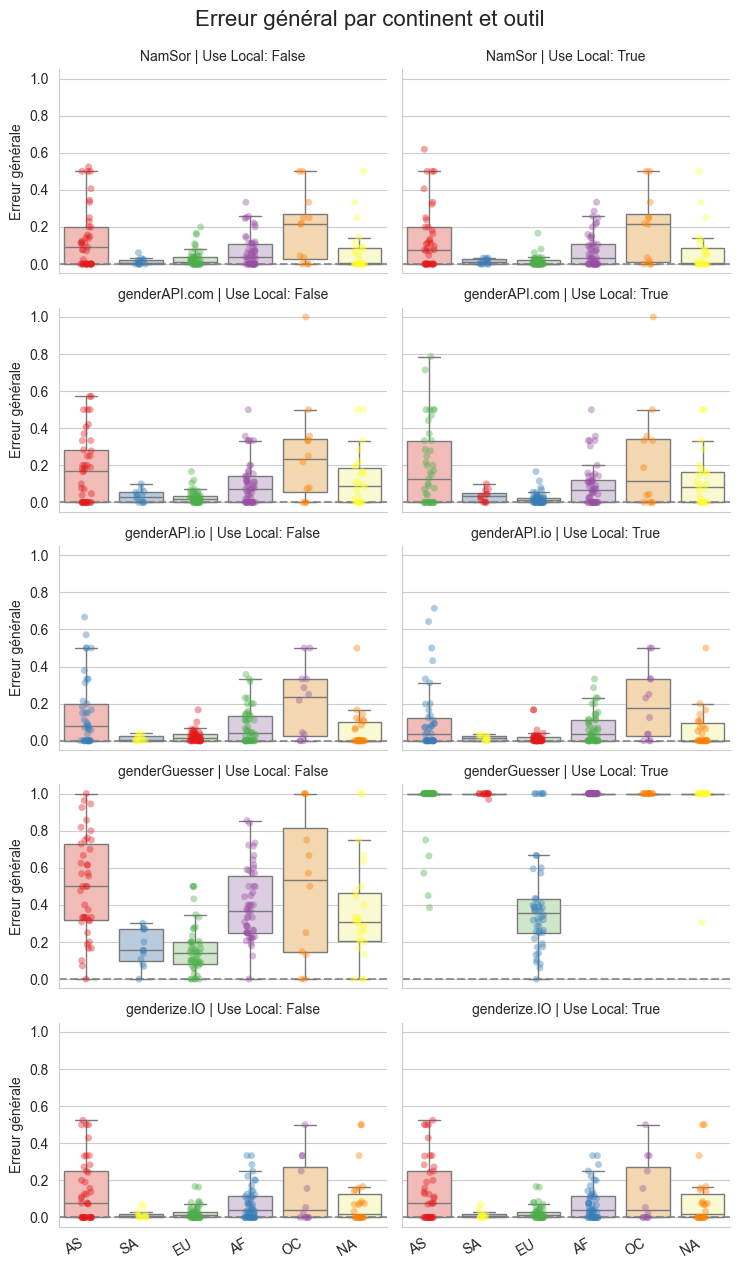

In [23]:
df = df_metricPerCountry.reset_index(drop=True)

# --- 2. Plotting ---
sns.set_style("whitegrid")

g = sns.catplot(
    data=df,
    x='continent',
    y='error_with_unknown',
    col='useLocal',
    row='service_used',
    kind='box',
    hue='continent',
    dodge=False,
    palette='Pastel1',   
    showfliers=False,    
    height=2.5,
    aspect=1.5
)

# On superpose les points bruts
g.map_dataframe(
    sns.stripplot,
    x='continent',
    y='error_with_unknown',
    hue='continent',
    palette='Set1',      
    alpha=0.4,            
    jitter=True,          
    dodge=False
)

g.map(plt.axhline, y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)

g.fig.suptitle('Erreur général par continent et outil', y=1.02, fontsize=16)
g.set_axis_labels("", "Erreur générale")
g.set_titles(col_template="Use Local: {col_name}", row_template="{row_name}")


# 3. Rotate X-Axis Labels (to fit "North America" etc.)
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

In [40]:
checkPivot = df_metricPerCountry.pivot_table(
    index=['service_used', 'continent'],
    columns='useLocal',
    values='error_gender_bias',
    # aggfunc='median'
).reset_index()

checkPivot = checkPivot.rename(columns={True: "erreur_with_var", False: "erreur_without_var"})


# checkPivot['erreur_without_var'] = checkPivot['erreur_without_var']*100
# checkPivot['erreur_with_var'] = checkPivot['erreur_with_var'] * 100
checkPivot['diff'] = checkPivot['erreur_without_var'] - checkPivot['erreur_with_var']

checkPivot.sort_values(by=['service_used', 'erreur_with_var']).round(3)

useLocal,service_used,continent,erreur_without_var,erreur_with_var,diff
1,NamSor,AS,-0.074,-0.080,0.007
3,NamSor,NA,-0.051,-0.051,0.000
0,NamSor,AF,-0.003,-0.005,0.002
5,NamSor,SA,-0.003,0.001,-0.004
2,NamSor,EU,0.016,0.003,0.013
4,NamSor,OC,0.041,0.124,-0.083
7,genderAPI.com,AS,-0.087,-0.101,0.014
9,genderAPI.com,NA,-0.024,-0.026,0.002
6,genderAPI.com,AF,-0.026,-0.020,-0.006
8,genderAPI.com,EU,0.005,0.005,-0.000


In [26]:
df_metricPerCountry.loc[(df_metricPerCountry['service_used']=='genderGuesser') & (df_metricPerCountry['continent']=='AF')]

,service_used,country,useLocal,population,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,continent
0,genderGuesser,SZ,False,2.0,0.500000,0.000000,0.500000,0.000000,0.166667,AF
0,genderGuesser,LS,False,3.0,0.666667,0.000000,0.666667,0.000000,0.285714,AF
0,genderGuesser,ST,False,3.0,0.333333,0.000000,0.333333,0.000000,0.090909,AF
0,genderGuesser,ML,False,46.0,0.717391,0.071429,0.695652,0.071429,0.362745,AF
0,genderGuesser,MZ,False,14.0,0.285714,0.000000,0.285714,0.000000,0.074074,AF
...,...,...,...,...,...,...,...,...,...,...
0,genderGuesser,RW,True,19.0,1.000000,NaN,1.000000,NaN,1.000000,AF
0,genderGuesser,SD,True,15.0,1.000000,NaN,1.000000,NaN,1.000000,AF
0,genderGuesser,SO,True,5.0,1.000000,NaN,1.000000,NaN,1.000000,AF
0,genderGuesser,CM,True,28.0,1.000000,NaN,1.000000,NaN,1.000000,AF


# Other

In [45]:
stat_df, metric_df = manager.runAnalysis(masterdf=df_master_noUnknown)

c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:20: SyntaxWarning: invalid escape sequence '\ '
  """


In [35]:
metric_df

,service_used,source,useLocal,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,NamSor,kaggle,True,0.054417,0.054417,0.000000,-0.011016,0.054417
0,NamSor,kaggle,False,0.067056,0.067056,0.000000,-0.009359,0.067056
0,NamSor,wikidata,True,0.060631,0.060631,0.000000,-0.015089,0.060631
0,NamSor,wikidata,False,0.069596,0.069596,0.000000,-0.018288,0.069596
0,genderAPI.com,kaggle,True,0.074192,0.047198,0.028332,-0.019061,0.052722
0,genderAPI.com,kaggle,False,0.084563,0.058757,0.027417,-0.021623,0.064034
0,genderAPI.com,wikidata,True,0.084643,0.055477,0.030880,-0.027596,0.061458
0,genderAPI.com,wikidata,False,0.090170,0.061321,0.030734,-0.029350,0.067236
0,genderAPI.io,kaggle,True,0.053101,0.053101,0.000000,-0.019610,0.053101
0,genderAPI.io,kaggle,False,0.068267,0.055053,0.013984,-0.010609,0.057726


In [36]:
stat_df

,service_used,source,statistic,p_value,b,c,odds_ratio,cohen_g,ci_low,ci_high
0,NamSor,kaggle,40.0,5.639881e-17,40,154,3.850000,0.587629,2.718944,5.451565
0,NamSor,wikidata,16.0,2.397320e-06,16,56,3.500000,0.555556,2.008032,6.100500
0,genderAPI.com,kaggle,77.0,1.643869e-09,77,172,2.233766,0.381526,1.707347,2.922495
0,genderAPI.com,wikidata,31.0,2.138319e-02,31,53,1.709677,0.261905,1.097602,2.663075
0,genderAPI.io,kaggle,118.0,1.062283e-12,118,255,2.161017,0.367292,1.737342,2.688011
0,genderAPI.io,wikidata,57.0,1.000000e+00,58,57,0.982759,-0.008696,0.681849,1.416464
0,genderGuesser,kaggle,719.0,0.000000e+00,3541,719,0.203050,-0.662441,0.187406,0.220000
0,genderGuesser,wikidata,300.0,9.136835e-238,1704,300,0.176056,-0.700599,0.155724,0.199043
0,genderize.IO,kaggle,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN
0,genderize.IO,wikidata,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN


## Mean of the base metric

In [40]:
mean_df = manager.getMeanMetric(metric_df)
mean_df.sort_values(by='error_with_unknown')

,service,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,NamSor,0.062925,0.062925,0.000000,-0.013438,0.062925
0,genderAPI.io,0.065183,0.061387,0.004024,-0.018977,0.062154
0,genderize.IO,0.069170,0.058141,0.011708,-0.016927,0.060368
0,genderAPI.com,0.083392,0.055688,0.029341,-0.024408,0.061362
0,genderGuesser,0.448059,0.030644,0.429680,-0.002361,0.178460


In [41]:
mean_df.columns

Index(['service', 'error_with_unknown', 'error_without_unknown',
       'error_unknown', 'error_gender_bias', 'weighted_error'],
      dtype='object')

In [42]:
N = 256
vals = np.ones((N, 4))

# Replace these by your two actual colors
start = np.array([160, 71, 64]) / 255    # normalize properly
end   = np.array([2, 79, 116]) / 255  # usually 1,1,1

for i in range(3):
    vals[:, i] = np.linspace(start[i], end[i], N)

postercmp = ListedColormap(vals)

In [43]:
test = manager.getMeanMetricPerState(metric_df)
test.sort_values(by=['service', 'useLocal'])

,service,useLocal,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,NamSor,False,0.068326,0.068326,0.000000,-0.013824,0.068326
0,NamSor,True,0.057524,0.057524,0.000000,-0.013052,0.057524
0,genderAPI.com,False,0.087367,0.060039,0.029075,-0.025487,0.065635
0,genderAPI.com,True,0.079418,0.051337,0.029606,-0.023328,0.057090
0,genderAPI.io,False,0.068424,0.061343,0.007500,-0.014966,0.062774
0,genderAPI.io,True,0.061942,0.061431,0.000549,-0.022988,0.061533
0,genderGuesser,False,0.273067,0.036166,0.245791,-0.002630,0.095144
0,genderGuesser,True,0.623050,0.025122,0.613569,-0.002092,0.261776
0,genderize.IO,False,0.069105,0.057843,0.011953,-0.016574,0.060117
0,genderize.IO,True,0.069235,0.058439,0.011463,-0.017280,0.060618


In [44]:
pourcent_df = mean_df.loc[:, mean_df.columns!='service' ] * 100

showcase_df = pd.concat([mean_df['service'], pourcent_df], axis=1)

showcase_df.reset_index(inplace=True)
showcase_df.sort_values(by='error_with_unknown', inplace=True)
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #c0c1c4; color: black;"
}

error_with_unknown = 'EG %'
error_without_unknown = 'E-NC'
showcase_df = showcase_df.rename(columns={
    'service' : 'outil',
    'error_with_unknown' : error_with_unknown, 
    'error_without_unknown' : error_without_unknown
})
showcase_df.style.hide(axis='index').format({
    error_with_unknown: "{:.2f} %",
    error_without_unknown: "{:.2f} %",
    "error_unknown": "{:.2f} %",
    "error_gender_bias": "{:.2f}",
    "weighted_error": "{:.2f} %",
}).background_gradient(subset=[error_with_unknown, error_without_unknown], cmap='RdYlGn_r').set_table_styles([headers])


index,outil,EG %,E-NC,error_unknown,error_gender_bias,weighted_error
0,NamSor,6.29 %,6.29 %,0.00 %,-1.34,6.29 %
0,genderAPI.io,6.52 %,6.14 %,0.40 %,-1.90,6.22 %
0,genderize.IO,6.92 %,5.81 %,1.17 %,-1.69,6.04 %
0,genderAPI.com,8.34 %,5.57 %,2.93 %,-2.44,6.14 %
0,genderGuesser,44.81 %,3.06 %,42.97 %,-0.24,17.85 %


In [199]:
pourcent_df = test.loc[:, test.columns.drop(['service', 'useLocal'])] * 100

showcase_df = pd.concat([test[['service', 'useLocal']], pourcent_df], axis=1)

showcase_df.reset_index(inplace=True)

showcase_df.sort_values(by=['useLocal'], inplace=True)

headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #c0c1c4; color: black;"
}

error_with_unknown = 'error %'
error_without_unknown = 'error % no unknown'
showcase_df = showcase_df.rename(columns={
    'service' : 'outil',
    'error_with_unknown' : error_with_unknown, 
    'error_without_unknown' : error_without_unknown
})
showcase_df.style.hide(axis='index').format({
    error_with_unknown: "{:.2f} %",
    error_without_unknown: "{:.2f} %",
    "error_unknown": "{:.2f} %",
    "error_gender_bias": "{:.2f}",
    "weighted_error": "{:.2f} %",
}).background_gradient(subset=[error_with_unknown, error_without_unknown], cmap='RdYlGn_r').set_table_styles([headers])


index,outil,useLocal,error %,error % no unknown,error_unknown,error_gender_bias,weighted_error
0,genderize.IO,False,6.91 %,5.78 %,1.20 %,-1.66,6.01 %
0,genderGuesser,False,27.31 %,3.62 %,24.58 %,-0.26,9.51 %
0,genderAPI.io,False,6.84 %,6.13 %,0.75 %,-1.50,6.28 %
0,genderAPI.com,False,8.74 %,6.00 %,2.91 %,-2.55,6.56 %
0,NamSor,False,6.83 %,6.83 %,0.00 %,-1.38,6.83 %
0,genderize.IO,True,6.92 %,5.84 %,1.15 %,-1.73,6.06 %
0,genderGuesser,True,62.30 %,2.51 %,61.36 %,-0.21,26.18 %
0,genderAPI.io,True,6.19 %,6.14 %,0.05 %,-2.30,6.15 %
0,genderAPI.com,True,7.94 %,5.13 %,2.96 %,-2.33,5.71 %
0,NamSor,True,5.75 %,5.75 %,0.00 %,-1.31,5.75 %


# Base metric without unknown

In [200]:
stat_NoUnknown_df, metric_NoUnknown_df = manager.runAnalysisWithoutUnknown(df_master_noUnknown) # the unknown here refer to different things
# the unknown on the master_df are unknown in the index (from a blunder of mine)
# the unknown in the metric and stat dfs are the version of those metrics where non-classifications are not taken into account

In [201]:
stat_NoUnknown_df

,service_used,source,statistic,p_value,b,c,odds_ratio,cohen_g,ci_low,ci_high
0,NamSor,kaggle,40.0,5.639881e-17,40,154,3.850000,0.587629,2.718944,5.451565
0,NamSor,wikidata,16.0,2.397320e-06,16,56,3.500000,0.555556,2.008032,6.100500
0,genderAPI.com,kaggle,64.0,1.266289e-11,64,166,2.593750,0.443478,1.943941,3.460773
0,genderAPI.com,wikidata,29.0,1.063749e-02,29,53,1.827586,0.292683,1.162159,2.874022
0,genderAPI.io,kaggle,118.0,1.504493e-03,118,173,1.466102,0.189003,1.160203,1.852654
0,genderAPI.io,wikidata,56.0,1.000000e+00,56,56,1.000000,0.000000,0.690455,1.448321
0,genderGuesser,kaggle,46.0,1.504186e-04,46,91,1.978261,0.328467,1.387684,2.820178
0,genderGuesser,wikidata,29.0,1.000000e+00,29,29,1.000000,0.000000,0.597667,1.673172
0,genderize.IO,kaggle,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN
0,genderize.IO,wikidata,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN


In [202]:
metric_NoUnknown_df

,service_used,source,useLocal,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,NamSor,kaggle,True,0.054417,0.054417,0.0,-0.011016,0.054417
0,NamSor,kaggle,False,0.067056,0.067056,0.0,-0.009359,0.067056
0,NamSor,wikidata,True,0.060631,0.060631,0.0,-0.015089,0.060631
0,NamSor,wikidata,False,0.069596,0.069596,0.0,-0.018288,0.069596
0,genderAPI.com,kaggle,True,0.047198,0.047198,0.0,-0.019061,0.047198
0,genderAPI.com,kaggle,False,0.058757,0.058757,0.0,-0.021623,0.058757
0,genderAPI.com,wikidata,True,0.055477,0.055477,0.0,-0.027596,0.055477
0,genderAPI.com,wikidata,False,0.061321,0.061321,0.0,-0.029350,0.061321
0,genderAPI.io,kaggle,True,0.053101,0.053101,0.0,-0.019610,0.053101
0,genderAPI.io,kaggle,False,0.055053,0.055053,0.0,-0.010609,0.055053


## Mean of the base metric without unknown

In [203]:
manager.getMeanMetric(metric_NoUnknown_df).sort_values(by='error_with_unknown')

,service,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,genderGuesser,0.030644,0.030644,0.0,-0.002361,0.030644
0,genderAPI.com,0.055688,0.055688,0.0,-0.024408,0.055688
0,genderize.IO,0.058141,0.058141,0.0,-0.016927,0.058141
0,genderAPI.io,0.061387,0.061387,0.0,-0.018977,0.061387
0,NamSor,0.062925,0.062925,0.0,-0.013438,0.062925


# Per country 

In [204]:
# genderGuesser throws a bit of a wrench in the machine here. We'll remove it for now
df_master_noGG = df_master_noUnknown.loc[
    (df_master_noUnknown['serviceUsed']!='genderGuesser'),
    # (df_master_noUnknown['predictedGender']!='unknown'), 
    :]

grouped = (
    df_master_noGG.groupby(["serviceUsed", "localization", "useLocalization"])
    ["isCorrect"]
    .sum()
    .reset_index()
)

pivoted = grouped.pivot_table(
    index=["serviceUsed", "localization"],
    columns="useLocalization",
    values="isCorrect",
    fill_value=0
).reset_index()

pivoted.columns.name = None
pivoted = pivoted.rename(columns={True: "correct_with_var", False: "correct_without_var"})

pivoted["improvement"] = pivoted["correct_with_var"] - pivoted["correct_without_var"]

country_impact = (
    pivoted.groupby("localization")["improvement"]
    .sum()
    .reset_index()
    .sort_values(by="improvement", ascending=False)
)

display(country_impact)
pivoted

,localization,improvement
91,JP,73.0
88,IT,37.0
187,US,33.0
25,BR,31.0
10,AU,21.0
...,...,...
42,CU,-3.0
183,TW,-3.0
99,KR,-6.0
167,SS,-22.0


,serviceUsed,localization,correct_without_var,correct_with_var,improvement
0,NamSor,AD,2.0,2.0,0.0
1,NamSor,AE,4.0,4.0,0.0
2,NamSor,AF,10.0,10.0,0.0
3,NamSor,AG,5.0,5.0,0.0
4,NamSor,AI,2.0,2.0,0.0
...,...,...,...,...,...
795,genderize.IO,WS,7.0,7.0,0.0
796,genderize.IO,YE,3.0,3.0,0.0
797,genderize.IO,ZA,197.0,197.0,0.0
798,genderize.IO,ZM,29.0,29.0,0.0


In [205]:
order_impact = country_impact.sort_values(by='improvement', ascending=False).reset_index()
order_impact

,index,localization,improvement
0,91,JP,73.0
1,88,IT,37.0
2,187,US,33.0
3,25,BR,31.0
4,10,AU,21.0
...,...,...,...
195,42,CU,-3.0
196,183,TW,-3.0
197,99,KR,-6.0
198,167,SS,-22.0


In [206]:
positive_impact =order_impact.loc[order_impact['improvement']>0,]
positive_impact['improvement'][5:,].sum()

np.float64(270.0)

In [207]:
positive_impact[['localization', 'improvement']].to_csv("C:/Users/brief/Desktop/Stuff I Like/The good stuff/lol.csv")

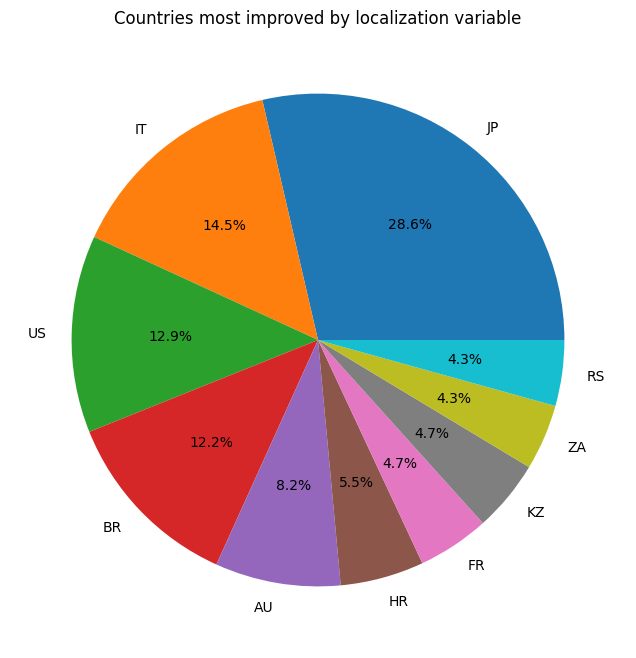

In [208]:
import matplotlib.pyplot as plt

top_countries = country_impact.head(10)  # top 10 most impacted
plt.figure(figsize=(8, 8))
plt.pie(top_countries["improvement"], labels=top_countries["localization"], autopct='%1.1f%%')
plt.title("Countries most improved by localization variable")
plt.show()

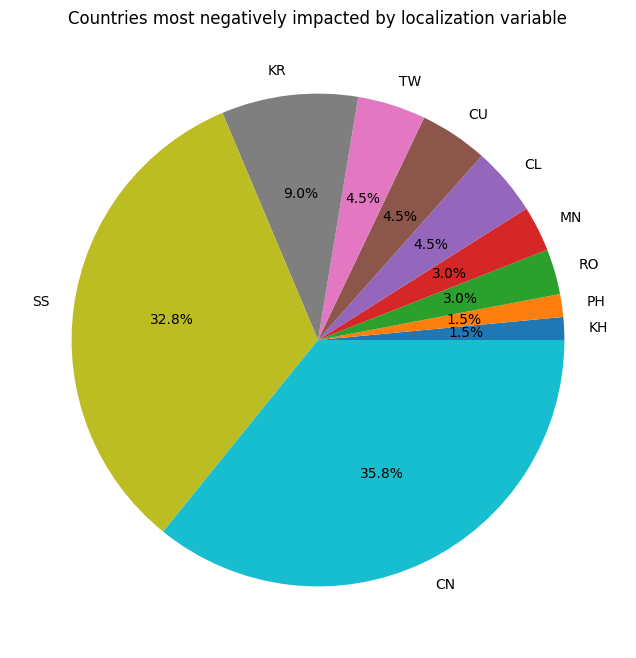

In [209]:
import matplotlib.pyplot as plt

top_countries = country_impact.tail(10)
plt.figure(figsize=(8, 8))
plt.pie(top_countries["improvement"]*-1, labels=top_countries["localization"], autopct='%1.1f%%')
plt.title("Countries most negatively impacted by localization variable")
plt.show()

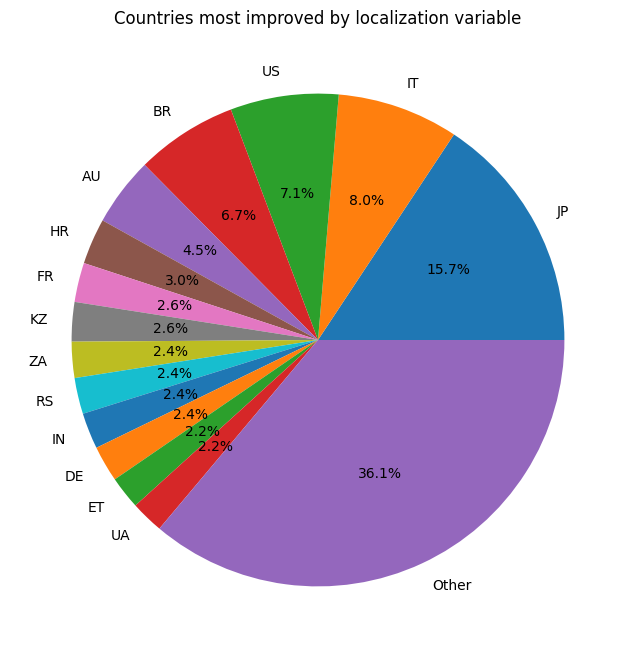

In [210]:
import matplotlib.pyplot as plt

top_countries = country_impact[country_impact['improvement']>0]
threshold = 10   # absolute threshold

vals = top_countries["improvement"]
labels = top_countries["localization"]

# Select large and small slices
large_mask = vals >= threshold
large_vals = vals[large_mask]
large_labels = labels[large_mask]

small_vals = vals[~large_mask]

# Add "Other" if needed
if len(small_vals) > 0:
    large_vals = pd.concat([large_vals, pd.Series([small_vals.sum()])], ignore_index=True)
    large_labels = pd.concat([large_labels, pd.Series(["Other"])], ignore_index=True)

# Plot
plt.figure(figsize=(8,8))
plt.pie(large_vals, labels=large_labels, autopct='%1.1f%%')
plt.title("Countries most improved by localization variable")
plt.show()

,serviceUsed,localization,correct_without_var,correct_with_var,improvement,n_without_var,n_with_var
0,NamSor,AD,2.0,2.0,0.0,2.0,2.0
1,NamSor,AE,4.0,4.0,0.0,5.0,5.0
2,NamSor,AF,10.0,10.0,0.0,10.0,10.0
3,NamSor,AG,5.0,5.0,0.0,5.0,5.0
4,NamSor,AI,2.0,2.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...
795,genderize.IO,WS,7.0,7.0,0.0,14.0,14.0
796,genderize.IO,YE,3.0,3.0,0.0,3.0,3.0
797,genderize.IO,ZA,197.0,197.0,0.0,219.0,219.0
798,genderize.IO,ZM,29.0,29.0,0.0,35.0,35.0


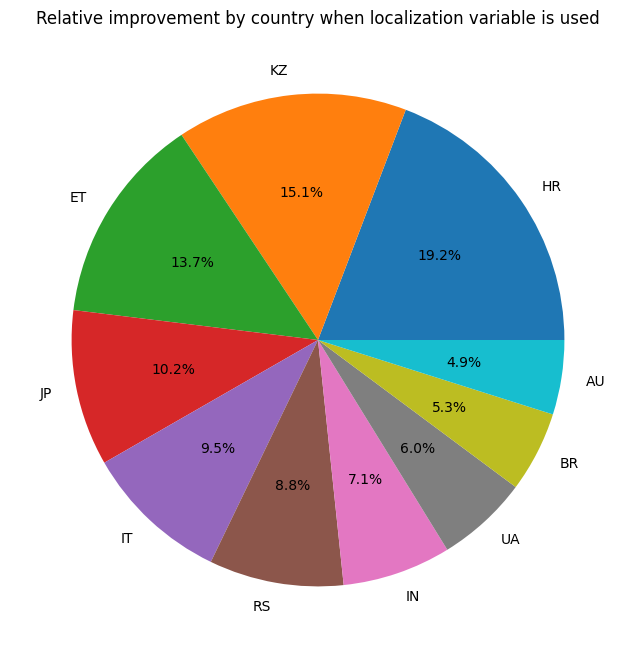

In [ ]:
# Step 1: Count how many total cases per (service, country, localization usage)
counts = (
    df_master_noGG.groupby(["serviceUsed", "localization", "useLocalization"])
    .size()
    .reset_index(name="n_cases")
)



# Step 2: merge those counts into the pivoted dataframe
pivoted = pivoted.merge(
    counts.pivot_table(
        index=["serviceUsed", "localization"],
        columns="useLocalization",
        values="n_cases",
        fill_value=0
    ).reset_index().rename(columns={True: "n_with_var", False: "n_without_var"}),
    on=["serviceUsed", "localization"],
    how="left"
)

# Step 3: compute improvement ratios
pivoted["improvement_abs"] = pivoted["correct_with_var"] - pivoted["correct_without_var"]
pivoted["improvement_ratio"] = pivoted["improvement_abs"] / (
    pivoted["n_with_var"] + pivoted["n_without_var"]
)

# Optional: percentage form
pivoted["improvement_pct"] = pivoted["improvement_ratio"] * 100

# Step 4: if you want per-country view across all services
country_impact = (
    pivoted.groupby("localization")[["improvement_abs", "improvement_ratio"]]
    .mean()
    .reset_index()
    .sort_values(by="improvement_ratio", ascending=False)
)



# Then you can easily visualize:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
top_countries = country_impact[country_impact['improvement_abs']>2].head(10)
plt.pie(
    top_countries["improvement_ratio"],
    labels=top_countries["localization"],
    autopct="%1.1f%%",
)
plt.title("Relative improvement by country when localization variable is used")
plt.show()


In [168]:
pivoted.sort_values(by='improvement_pct', ascending=True)

,serviceUsed,localization,correct_without_var,correct_with_var,improvement,n_without_var,n_with_var,improvement_abs,improvement_ratio,improvement_pct
367,genderAPI.com,SS,23.0,0.0,-23.0,25.0,0.0,-23.0,-0.920000,-92.000000
294,genderAPI.com,KH,3.0,2.0,-1.0,4.0,4.0,-1.0,-0.125000,-12.500000
383,genderAPI.com,TW,6.0,3.0,-3.0,14.0,14.0,-3.0,-0.107143,-10.714286
403,genderAPI.io,AG,5.0,4.0,-1.0,5.0,5.0,-1.0,-0.100000,-10.000000
415,genderAPI.io,BD,6.0,5.0,-1.0,6.0,6.0,-1.0,-0.083333,-8.333333
...,...,...,...,...,...,...,...,...,...,...
576,genderAPI.io,TL,2.0,3.0,1.0,3.0,3.0,1.0,0.166667,16.666667
503,genderAPI.io,LA,1.0,2.0,1.0,2.0,2.0,1.0,0.250000,25.000000
476,genderAPI.io,HK,1.0,2.0,1.0,2.0,2.0,1.0,0.250000,25.000000
535,genderAPI.io,NR,0.0,1.0,1.0,1.0,1.0,1.0,0.500000,50.000000


# Genderize

In [155]:
df_Genderize_wikidata_Country = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/Genderize/wikidataFirstCountryPre.csv")
df_Genderize_wikidata_NoCountry = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/Genderize/wikidataFirstNoCountryPre.csv")
eval_genderize_wikidata_Country = Evaluator(df_Genderize_wikidata_Country)
eval_genderize_wikidata_NoCountry = Evaluator(df_Genderize_wikidata_NoCountry)

## Performance metrics

In [156]:
confMatrixGenderizeWikiCountry = eval_genderize_wikidata_Country.get_confusion_matrix()
eval_genderize_wikidata_Country.compute_all_errors(confMatrixGenderizeWikiCountry)

{'error_with_unknown': np.float64(0.07160493827160494),
 'error_without_unknown': np.float64(0.06156405990016639),
 'error_unknown': np.float64(0.010699588477366255),
 'error_gender_bias': np.float64(-0.02273987798114254),
 'weighted_error': np.float64(0.06358957330234102)}

In [157]:
confMatrixGenderizeWikiNoCountry = eval_genderize_wikidata_NoCountry.get_confusion_matrix()
eval_genderize_wikidata_Country.compute_all_errors(confMatrixGenderizeWikiNoCountry)

{'error_with_unknown': np.float64(0.07137414274828549),
 'error_without_unknown': np.float64(0.06039578514520689),
 'error_unknown': np.float64(0.011684023368046735),
 'error_gender_bias': np.float64(-0.021331277306604987),
 'weighted_error': np.float64(0.06261217373468027)}

## Stastical testing

In [158]:
testerGenderize = StatisticalTester(df_iso=df_Genderize_wikidata_Country, df_noiso=df_Genderize_wikidata_NoCountry)
testerGenderize.summarize()

{'paired_result': {'test': 'McNemar',
  'statistic': np.float64(0.0),
  'p_value': np.float64(1.0),
  'b': np.int64(0),
  'c': np.int64(0),
  'odds_ratio': inf,
  'ci_low': nan,
  'ci_high': nan,
  'cohen_g': nan,
  'table': array([[3384,    0],
         [   0,  261]])}}

The McNemar test take the two set based on the Wikidata set and uses only the samples that are present in both, which mean that the results in based on only the samples that were given an ISO code, and then tested with and without this information. 

The result of the test, with a p-value of 1, mean that they are not ANY traces of a difference between using the ISO code or not using it. 

In [ ]:
try:
    del df_Genderize_wikidata_Country
    del df_Genderize_wikidata_NoCountry
    del confMatrixGenderizeWikiCountry
    del confMatrixGenderizeWikiNoCountry
    del eval_genderize_wikidata_Country
    del eval_genderize_wikidata_NoCountry

except:
    pass

# GenderAPI.io

## Performance Metric

In [160]:
df_GenderAPIio_wikidata_Country = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/GenderAPIIO/wikidataFirstCountryPre.csv")
df_GenderAPIio_wikidata_NoCountry = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/GenderAPIIO/wikidataFirstNoCountryPre.csv")

eval_genderAPIio_wikidataCountry = Evaluator(df_GenderAPIio_wikidata_Country)
eval_genderAPIio_wikidataNoCountry = Evaluator(df_GenderAPIio_wikidata_NoCountry)

In [161]:
confMatrixGenderAPIioWikiCountry = eval_genderAPIio_wikidataCountry.get_confusion_matrix()
eval_genderAPIio_wikidataCountry.compute_all_errors(confMatrixGenderAPIioWikiCountry)

{'error_with_unknown': np.float64(0.09108367626886145),
 'error_without_unknown': np.float64(0.060674794442869294),
 'error_unknown': np.float64(0.032373113854595334),
 'error_gender_bias': np.float64(-0.026651545222568754),
 'weighted_error': np.float64(0.0669182673350983)}

In [162]:
confMatrixGenderAPIioWikiNoCountry = eval_genderAPIio_wikidataNoCountry.get_confusion_matrix()
eval_genderAPIio_wikidataNoCountry.compute_all_errors(confMatrixGenderAPIioWikiNoCountry)

{'error_with_unknown': np.float64(0.07874015748031496),
 'error_without_unknown': np.float64(0.05914396887159533),
 'error_unknown': np.float64(0.02082804165608331),
 'error_gender_bias': np.float64(-0.020233463035019456),
 'weighted_error': np.float64(0.0631296171927468)}

In [163]:
df_GenderAPIio_kaggle_Country = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/GenderAPIIO/kaggleFirstCountryPre.csv")
df_GenderAPIio_kaggle_NoCountry = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/GenderAPIIO/kaggleFirstNoCountryPre.csv")

eval_genderAPIio_kaggleCountry = Evaluator(df_GenderAPIio_kaggle_Country)
eval_genderAPIio_kaggleNoCountry = Evaluator(df_GenderAPIio_kaggle_NoCountry)

In [164]:
confMatrixGenderAPIiokaggleCountry = eval_genderAPIio_kaggleCountry.get_confusion_matrix()
eval_genderAPIio_kaggleCountry.compute_all_errors(confMatrixGenderAPIiokaggleCountry)

{'error_with_unknown': np.float64(0.04612943443273263),
 'error_without_unknown': np.float64(0.04612943443273263),
 'error_unknown': np.float64(0.0),
 'error_gender_bias': np.float64(-0.02232800634704749),
 'weighted_error': np.float64(0.04612943443273263)}

In [165]:
confMatrixGenderAPIiokaggleNoCountry = eval_genderAPIio_kaggleNoCountry.get_confusion_matrix()
eval_genderAPIio_kaggleNoCountry.compute_all_errors(confMatrixGenderAPIiokaggleNoCountry)

{'error_with_unknown': np.float64(0.04644313547802447),
 'error_without_unknown': np.float64(0.046335108190778296),
 'error_unknown': np.float64(0.00011327594019030358),
 'error_gender_bias': np.float64(-0.022544465843434915),
 'weighted_error': np.float64(0.04635671560630777)}

## Statistical testing

In [166]:
testerGenderAPIIo = StatisticalTester(df_iso=df_GenderAPIio_wikidata_Country, df_noiso=df_GenderAPIio_wikidata_NoCountry)
testerGenderAPIIo.summarize()

{'paired_result': {'test': 'McNemar',
  'statistic': np.float64(41.0),
  'p_value': np.float64(0.0011783931030854484),
  'b': np.int64(77),
  'c': np.int64(41),
  'odds_ratio': np.float64(0.5324675324675324),
  'ci_low': 0.36452357641281324,
  'ci_high': 0.7777869292354959,
  'cohen_g': np.float64(-0.3050847457627119),
  'table': array([[3272,   77],
         [  41,  255]])}}

This McNemar's Test produce a surprising result. With $\chi^2=41$ and a $p=0.0011$, this indicate a significant change in prediction accuracy when providing, or not, the ISO code, meaning the null hypothese is discarded. 

However, the surprise takes form when looking at the direction of this change. Given the contingency table with values b=77 and c=41, this indicate that the accuracy went *down* when providing the ISO code, which goes contrary to what we might expect.  

# GenderAPI.com

In [167]:
df_GenderAPIcom_wikidata_Country = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/GenderAPIcom/wikidataFirstCountryPre.csv")
df_GenderAPIcom_wikidata_NoCountry = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/GenderAPIcom/wikidataFirstNoCountryPre.csv")

eval_genderAPIcom_wikidata_country = Evaluator(df_GenderAPIcom_wikidata_Country)
eval_genderAPIcom_wikidata_nocountry = Evaluator(df_GenderAPIcom_wikidata_NoCountry)

## Performance metric

In [168]:
confMatrixGenderAPIcomWikiCountry = eval_genderAPIcom_wikidata_country.get_confusion_matrix()
eval_genderAPIcom_wikidata_country.compute_all_errors(confMatrixGenderAPIcomWikiCountry)

{'error_with_unknown': np.float64(0.08464295561069754),
 'error_without_unknown': np.float64(0.05547652916073969),
 'error_unknown': np.float64(0.030879514750482492),
 'error_gender_bias': np.float64(-0.02759601706970128),
 'weighted_error': np.float64(0.061457567705094134)}

In [169]:
confMatrixGenderAPIcomWikiNoCountry = eval_genderAPIcom_wikidata_nocountry.get_confusion_matrix()
eval_genderAPIcom_wikidata_nocountry.compute_all_errors(confMatrixGenderAPIcomWikiNoCountry)

{'error_with_unknown': np.float64(0.09017018034036069),
 'error_without_unknown': np.float64(0.06132075471698113),
 'error_unknown': np.float64(0.030734061468122936),
 'error_gender_bias': np.float64(-0.029350104821802937),
 'weighted_error': np.float64(0.06723608145409093)}

## Stastical testing

In [170]:
testerGenderAPIcom = StatisticalTester(df_iso=df_GenderAPIcom_wikidata_Country, df_noiso=df_GenderAPIcom_wikidata_NoCountry)
testerGenderAPIcom.summarize()

{'paired_result': {'test': 'McNemar',
  'statistic': np.float64(31.0),
  'p_value': np.float64(0.021383189937144585),
  'b': np.int64(31),
  'c': np.int64(53),
  'odds_ratio': np.float64(1.7096774193548387),
  'ci_low': 1.0976022143412096,
  'ci_high': 2.6630748736291765,
  'cohen_g': np.float64(0.2619047619047619),
  'table': array([[3267,   31],
         [  53,  276]])}}

Given the table, this test reverse the tendencies we saw so far. The McNemar test ($\chi^2$ = 31.0, p = 0.021) indicates a statistically significant difference in prediction outcomes when including the ISO country code. Since more names were correctly classified with the ISO information (c = 53) than without it (b = 31), the inclusion of country information has a positive effect on prediction accuracy for GenderAPI.com.  

# Namsor

In [171]:
df_Namsor_Wikidata_Country = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/Namsor/wikidataFirstCountryPre.csv")
df_Namsor_Wikidata_NoCountry = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/Namsor/wikidataFirstNoCountryPre.csv")

eval_Namsor_Wikidata_country = Evaluator(df_Namsor_Wikidata_Country)
eval_Namsor_Wikidata_Nocountry = Evaluator(df_Namsor_Wikidata_NoCountry)

## Performance

In [172]:
confMatrixNamsorWikidataCountry = eval_Namsor_Wikidata_country.get_confusion_matrix()
eval_Namsor_Wikidata_country.compute_all_errors(confMatrixNamsorWikidataCountry)

{'error_with_unknown': np.float64(0.06063100137174211),
 'error_without_unknown': np.float64(0.06063100137174211),
 'error_unknown': np.float64(0.0),
 'error_gender_bias': np.float64(-0.015089163237311385),
 'weighted_error': np.float64(0.06063100137174211)}

In [173]:
confMatrixNamSorWikidataNoCountry = eval_Namsor_Wikidata_Nocountry.get_confusion_matrix()
eval_Namsor_Wikidata_Nocountry.compute_all_errors(confMatrixNamSorWikidataNoCountry)

{'error_with_unknown': np.float64(0.06959613919227839),
 'error_without_unknown': np.float64(0.06959613919227839),
 'error_unknown': np.float64(0.0),
 'error_gender_bias': np.float64(-0.01828803657607315),
 'weighted_error': np.float64(0.06959613919227839)}

## Statistical testing

In [174]:
testerNamsor = StatisticalTester(df_iso=df_Namsor_Wikidata_Country, df_noiso=df_Namsor_Wikidata_NoCountry)
testerNamsor.summarize()

{'paired_result': {'test': 'McNemar',
  'statistic': np.float64(16.0),
  'p_value': np.float64(2.397319809534421e-06),
  'b': np.int64(16),
  'c': np.int64(56),
  'odds_ratio': np.float64(3.5),
  'ci_low': 2.0080321108721284,
  'ci_high': 6.100500053597042,
  'cohen_g': np.float64(0.5555555555555556),
  'table': array([[3368,   16],
         [  56,  205]])}}

Namsor follows the new trend of GenderAPI.com to be, unsurprisingly, better when being provided with the ISO code. With a $\chi^2=16$ and $p \cong 0.000002$, the null hypothesis is thrown out and the influence of the ISO code is noteworthy. Similarly, the direction of this influence align with the result of GenderAPI.com, with Namsor Producing better results when shown the ISO code. 

# Gender Guesser

In [175]:
df_GG_wikidata_Country = df_masterTest[
    (df_masterTest['source'] == 'wikidata') &
    (df_masterTest['serviceUsed'] == 'genderGuesser') & 
    (df_masterTest['useLocalization'] == True)
]
df_GG_wikidata_NoCountry = df_masterTest[
    (df_masterTest['source'] == 'wikidata') &
    (df_masterTest['serviceUsed'] == 'genderGuesser') & 
    (df_masterTest['useLocalization'] == False)
]
print(df_GG_wikidata_Country.shape)
print(df_GG_wikidata_NoCountry.shape)

df_gg_kaggle_country = df_masterTest[
    (df_masterTest['source'] == 'kaggle') &
    (df_masterTest['serviceUsed'] == 'genderGuesser') & 
    (df_masterTest['useLocalization'] == True)
]
df_gg_kaggle_Nocountry = df_masterTest[
    (df_masterTest['source'] == 'kaggle') &
    (df_masterTest['serviceUsed'] == 'genderGuesser') & 
    (df_masterTest['useLocalization'] == False)
]

print(df_gg_kaggle_country.shape)
print(df_gg_kaggle_Nocountry.shape)

(3645, 24)
(3937, 24)
(9078, 24)
(9082, 24)


## Perfomance testing

In [176]:
eval_gg_wikidata_country = Evaluator(df_GG_wikidata_Country)
eval_gg_wikidata_Nocountry = Evaluator(df_GG_wikidata_NoCountry)

confMatrxGGWikidataCountry = eval_gg_wikidata_country.get_confusion_matrix()
confMatrxGGWikidataNoCountry = eval_gg_wikidata_Nocountry.get_confusion_matrix()

eval_gg_wikidata_country.compute_all_errors(confMatrxGGWikidataCountry)

{'error_with_unknown': np.float64(0.663923182441701),
 'error_without_unknown': np.float64(0.030854430379746837),
 'error_unknown': np.float64(0.6532235939643347),
 'error_gender_bias': np.float64(-0.0023734177215189874),
 'weighted_error': np.float64(0.29605792437650846)}

In [177]:
eval_gg_wikidata_Nocountry.compute_all_errors(confMatrxGGWikidataNoCountry)

{'error_with_unknown': np.float64(0.2748285496570993),
 'error_without_unknown': np.float64(0.03677462887989204),
 'error_unknown': np.float64(0.24714249428498858),
 'error_gender_bias': np.float64(-0.0043859649122807015),
 'weighted_error': np.float64(0.09611853352751219)}

In [178]:
eval_gg_kaggle_Country = Evaluator(df_gg_kaggle_country)
eval_gg_kaggle_NoCountry = Evaluator(df_gg_kaggle_Nocountry)

confmatrixGGKaggleCountry = eval_gg_kaggle_Country.get_confusion_matrix()
confmatrixGGKaggleNoCountry = eval_gg_kaggle_NoCountry.get_confusion_matrix()

eval_gg_kaggle_Country.compute_all_errors(confmatrixGGKaggleCountry)

{'error_with_unknown': np.float64(0.5821766909010795),
 'error_without_unknown': np.float64(0.01938986556359876),
 'error_unknown': np.float64(0.5739149592421238),
 'error_gender_bias': np.float64(-0.0018097207859358842),
 'weighted_error': np.float64(0.2274949083503055)}

In [179]:
eval_gg_kaggle_NoCountry.compute_all_errors(confmatrixGGKaggleNoCountry)

{'error_with_unknown': np.float64(0.2713058797621669),
 'error_without_unknown': np.float64(0.03555814631302827),
 'error_unknown': np.float64(0.24443955075974455),
 'error_gender_bias': np.float64(-0.0008743806470416788),
 'weighted_error': np.float64(0.09416917601970982)}

The GenderGuesser library is a odd case among the tools we're testing here. 

While it has some of the worst `error_with_unknown` metric out of all of our tools, it also has the best `error_without_unknown` metrics. This indicate a pattern where GenderGuesser avoid doing any classification when it can not be sure, thus producing a lot of non-classification that worsen its overall accuracy. When it does however produce a classification, it is the most accurate we have so far. 

## Stastical testing

In [180]:
testerGGwikidata = StatisticalTester(df_GG_wikidata_Country, df_GG_wikidata_NoCountry)
testerGGwikidata.summarize()


{'paired_result': {'test': 'McNemar',
  'statistic': np.float64(300.0),
  'p_value': np.float64(9.136835219151124e-238),
  'b': np.int64(1704),
  'c': np.int64(300),
  'odds_ratio': np.float64(0.176056338028169),
  'ci_low': 0.15572407579149897,
  'ci_high': 0.1990433014442137,
  'cohen_g': np.float64(-0.7005988023952096),
  'table': array([[ 925, 1704],
         [ 300,  716]])}}

In [181]:
testerGGKaggle = StatisticalTester(df_gg_kaggle_country, df_gg_kaggle_Nocountry)
summaryGGKaggle = testerGGKaggle.summarize()
summaryGGKaggle

{'paired_result': {'test': 'McNemar',
  'statistic': np.float64(423.0),
  'p_value': np.float64(7.033184079100331e-171),
  'b': np.int64(1652),
  'c': np.int64(423),
  'odds_ratio': np.float64(0.2560532687651332),
  'ci_low': 0.23011539812325302,
  'ci_high': 0.2849147731095897,
  'cohen_g': np.float64(-0.592289156626506),
  'table': array([[2004, 1652],
         [ 423,  929]])}}

Those two McNemar's test we ran here are significant. With both pvalue being extremely low (in fact, the second test produced a pvalue so low, it made the float type variable holding it reduce it to 0), we can safely discord $H_0$, and say that adding the ISO code does change significantly the result. The direction of this change is given by the difference between our $b$ and $c$ value, where $b$ is much higher, meaning giving the ISO code actually worsen the quality of the prediction. 

This effect is important, with a value $g$ being > 0.65 in both case, indicating a medium to strong effect. With an odd ration of ~0.203, the case where GG is harmed by the introduction of the country of origin is about 5x more likely when  

In [182]:
df_gg_kaggle_countryNoNa = df_gg_kaggle_country[df_gg_kaggle_country['predictedGender'] != 'unknown']
df_gg_kaggle_NocountryNoNa = df_gg_kaggle_Nocountry[df_gg_kaggle_Nocountry['predictedGender'] != 'unknown']


testerGGKaggle = StatisticalTester(df_gg_kaggle_countryNoNa, df_gg_kaggle_NocountryNoNa)
summaryGGKaggle = testerGGKaggle.summarize()
summaryGGKaggle

{'paired_result': {'test': 'McNemar',
  'statistic': np.float64(20.0),
  'p_value': np.float64(0.00014163707253552724),
  'b': np.int64(20),
  'c': np.int64(53),
  'odds_ratio': np.float64(2.65),
  'ci_low': 1.5843951753421448,
  'ci_high': 4.432290699498951,
  'cohen_g': np.float64(0.4520547945205479),
  'table': array([[2004,   20],
         [  53,    8]])}}

GenderGuesser, as already remarked before, is a tool that is very hesitant, which lead it to produce a lot of unknown result which penalize it heavily during those stastical test. When removing the unknown rows (non-classification) of the dataset and focusing only on the case where it did produce a classification (even mis-classification), we see its performances rise importantly. In this case, the null hypothesis is still rejected given that p<0.05, but the odd ration and cohen's g clearly indicate that the effect is, this time, very positive. 

# Debugging HELP ME

In [183]:
df_gg_kaggle = df_masterTest[(df_masterTest['serviceUsed']=='genderize')&(df_masterTest['source']=='kaggle')]

In [184]:
df_gg_kaggle[df_gg_kaggle['useLocalization']==False]


,index,fullName,namePassed,correctGender,predictedGender,localization,useLocalization,serviceUsed,extra_useFullName,extraProbability,...,extraTotalName,extraCountryUsedByService,extraUsedAI,extraForcedGenderize,extraPreciseGenderPredicted,extraCount,extraGenderScale,extraScore,extraProbabilityCalibrated,extraScript
